<a href="https://colab.research.google.com/github/zehrayavuz01/CFRAG/blob/main/CFRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
from collections import defaultdict

jsonl_path = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/sephora_data/lamp3_train.jsonl"

import json
from collections import defaultdict



user_hist_counts = defaultdict(int)

with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        uid = data["user_id"]
        review_count = len(data.get("history", [])) + 1
        user_hist_counts[uid] = max(user_hist_counts[uid], review_count)

num_users           = len(user_hist_counts)
users_gt10_reviews  = sum(1 for c in user_hist_counts.values() if c > 10)

print("Distinct users:", num_users)
print("Users with > 10 reviews:", users_gt10_reviews)

Distinct users: 105750
Users with > 10 reviews: 4722


In [ ]:
import os
os.chdir('/content/drive/MyDrive/bitirme_projesi/CFRAG_local')
print("Working dir:", os.getcwd())

Working dir: /content/drive/MyDrive/bitirme_projesi/CFRAG_local


In [ ]:
import os, json
from pathlib import Path

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
DATA_IN = f"{BASE}/sephora_data"     # where lamp3_{train,dev}.jsonl live
DATA_OUT = f"{BASE}/data/LaMP_3_time"  # what preprocess_profile.py expects

os.makedirs(f"{DATA_OUT}/train", exist_ok=True)
os.makedirs(f"{DATA_OUT}/dev", exist_ok=True)

def convert(split):
    in_path = f"{DATA_IN}/lamp3_{split}.jsonl"
    q_out   = f"{DATA_OUT}/{split}/{split}_questions.json"
    o_out   = f"{DATA_OUT}/{split}/{split}_outputs.json"

    questions = []
    golds = []
    with open(in_path, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            ex = json.loads(line)
            ex_id = f"{ex['user_id']}::{ex['item_id']}::{idx}"


            profile = []
            day = 1
            for h in ex.get("history", []):
                profile.append({
                    "text": h.get("text", ""),
                    "label": h.get("label", ""),
                    "date": f"2000-01-{day:02d}"   # monotonic placeholder keeps original order
                })
                day += 1

            questions.append({
                "id": ex_id,
                "input": ex.get("input",""),
                "profile": profile,
                "user_id": ex.get("user_id","")
            })
            golds.append({
                "id": ex_id,
                "output": ex.get("label","")
            })

    with open(q_out, "w", encoding="utf-8") as f:
        json.dump(questions, f, ensure_ascii=False, indent=2)

    with open(o_out, "w", encoding="utf-8") as f:
        json.dump({"task": "LaMP_3_time", "golds": golds}, f, ensure_ascii=False, indent=2)

    print(f"✓ Wrote {q_out} and {o_out}")

convert("train")
convert("dev")

✓ Wrote /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/train_questions.json and /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/train_outputs.json
✓ Wrote /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/dev_questions.json and /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/dev_outputs.json


In [ ]:
!python data/preprocess_profile.py --task LaMP_3_time --data_phase train --ranker recency
!python data/preprocess_profile.py --task LaMP_3_time --data_phase dev --ranker recency

python3: can't open file '/content/data/preprocess_profile.py': [Errno 2] No such file or directory
python3: can't open file '/content/data/preprocess_profile.py': [Errno 2] No such file or directory


RUNTIME DEĞİŞTİ

In [ ]:
from google.colab import drive; drive.mount('/content/drive')
import os; os.chdir('/content/drive/MyDrive/bitirme_projesi/CFRAG_local')
print("wd:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
wd: /content/drive/MyDrive/bitirme_projesi/CFRAG_local


In [ ]:
# 1) create the package marker
%%bash
cd /content/drive/MyDrive/bitirme_projesi/CFRAG_local
mkdir -p prompts
touch prompts/__init__.py
ls -la prompts

total 26
-rw------- 1 root root     0 Nov 23 09:45 __init__.py
-rw------- 1 root root  3623 Nov  8 09:39 post_process.py
-rw------- 1 root root  4497 Nov  8 09:39 pre_process.py
-rw------- 1 root root 13202 Nov  8 09:39 prompts.py
drwx------ 2 root root  4096 Nov 23 09:20 __pycache__


In [ ]:
# 2) make sure Python can import from your repo root
import sys, os
sys.path.append('/content/drive/MyDrive/bitirme_projesi/CFRAG_local')
print('in sys.path?', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local' in sys.path)

# quick import sanity check
from prompts.pre_process import load_get_corpus_fn
print('OK ->', callable(load_get_corpus_fn))

in sys.path? True
OK -> True


In [ ]:
!pip -q install sentence-transformers transformers faiss-cpu tqdm
# If you see a torch error later, add:
# pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 86.4 MB/s eta 0:00:00


In [ ]:
# build per-user sets from rank_merge.json
!python user_emb/get_user_set.py --task LaMP_3_time --data_phase train --ranker recency
!python user_emb/get_user_set.py --task LaMP_3_time --data_phase dev   --ranker recency

# build/encode the item/user corpus (uses prompts.pre_process.load_get_corpus_fn)
!python user_emb/get_corpus_emb.py --task LaMP_3_time --data_phase train --ranker recency

python3: can't open file '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/get_user_set.py': [Errno 2] No such file or directory
python3: can't open file '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/get_user_set.py': [Errno 2] No such file or directory
python3: can't open file '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/get_corpus_emb.py': [Errno 2] No such file or directory


In [ ]:
!cd /content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb
!python run.py --task LaMP_3_time --data_phase train --ranker recency
!cd -  # back to root

python3: can't open file '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/run.py': [Errno 2] No such file or directory
/


In [ ]:

import os, glob
base = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb"
print(os.path.isdir(base))
print(glob.glob(base+"/*"))


True
['/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/get_corpus_emb.py', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/arguments.py', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/data.py', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/modeling.py', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/run.py', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/utils.py', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/__pycache__', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/get_user_set.py', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/checkpoints', '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/trainer.py']


In [ ]:
!python user_emb/get_user_set.py  --task LaMP_3_time --data_phase train --ranker recency
!python user_emb/get_corpus_emb.py --task LaMP_3_time --data_phase train --ranker recency

python3: can't open file '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/get_user_set.py': [Errno 2] No such file or directory
python3: can't open file '/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/get_corpus_emb.py': [Errno 2] No such file or directory


Training

-- set project root & import path


In [ ]:
#
BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
import sys, os
sys.path.append(BASE)  # so `prompts` can be imported
os.chdir(BASE)
print("wd:", os.getcwd())

wd: /content/drive/MyDrive/bitirme_projesi/CFRAG_local


--sanity check, optional
must return true true


In [ ]:
import os
print(os.path.exists(f"{BASE}/user_emb/train_user_emb/get_user_set.py"))
print(os.path.exists(f"{BASE}/user_emb/train_user_emb/get_corpus_emb.py"))

True
True


--get_corpus_emb (dev) with correct flags/model  Optional template

In [ ]:
!python /content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/get_corpus_emb.py \
  --task LaMP_3_time \
  --source recency \
  --stage dev \
  --emb_model_path BAAI/bge-base-en-v1.5 \
  --emb_model_pooling mean \
  --emb_model_normalize 1 \
  --batch_size 128 \
  --device cuda:0

CUDA_VISIBLE_DEVICES: 0,1
device: cuda:0
batch_size: 128
emb_model_path: BAAI/bge-base-en-v1.5
emb_model_pooling: mean
emb_type: mean
emb_model_normalize: 1
max_length: 512
task: LaMP_3_time
source: recency
stage: dev
input_path: data/LaMP_3_time/dev/recency
corpus_emb_path: data/LaMP_3_time/dev/recency/corpus_emb/bge-base-en-v1.5_mean.pt
2025-11-08 12:41:38.026035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762605698.057999   54287 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762605698.067802   54287 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762605698.092115   54287 computation_placer.cc:177] computation placer already regi

-- find corpus emb files 🟨 Optional

In [ ]:
!find /content/drive/MyDrive/bitirme_projesi/CFRAG_local -iname "*corpus*emb*"

/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/corpus_emb
/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/corpus_emb
/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/get_corpus_emb.py


Shows accepted flags get_user_set.py -h 🟨 Optional

In [ ]:
# see which flags it accepts
!python /content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/get_user_set.py -h

usage: get_user_set.py [-h] [--task TASK] [--source SOURCE]
                       [--cut_his_len CUT_HIS_LEN]

options:
  -h, --help            show this help message and exit
  --task TASK
  --source SOURCE
  --cut_his_len CUT_HIS_LEN


-- 43 — get_user_set (patched) ✅ KEEP (run when pkl missing or data changed)
	•	Generates user_vocab.pkl, user2id.pkl, corpus_vocab.pkl, corpus2id.pkl for both train/recency and dev/recency.
	•	After your patch (remove assert & save both splits), this is idempotent.
	•	Re-run if you reset and the data/.../*vocab.pkl files aren’t present, or if your rank_merge.json changes.
  

In [ ]:
!python /content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/get_user_set.py \
  --task LaMP_3_time \
  --source recency \
  --cut_his_len 30       # optional; history length cap

task: LaMP_3_time
100% 331801/331801 [00:02<00:00, 140229.11it/s]
100% 48926/48926 [00:00<00:00, 254044.47it/s]
num user: 105750
num corpus: 340767
100% 331801/331801 [00:03<00:00, 87440.86it/s]
100% 48926/48926 [00:00<00:00, 94653.08it/s]
                 len
count  105750.000000
mean        2.677778
std         2.283017
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        10.000000
✅ Saved vocab files to both train and dev.


In [ ]:
!ls /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/
!ls /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/

corpus2id.pkl  corpus_vocab.pkl  user2id.pkl  user_vocab.pkl
corpus_emb     rank_merge.json	 user_emb
corpus2id.pkl  corpus_vocab.pkl  user2id.pkl
corpus_emb     rank_merge.json	 user_vocab.pkl


get_corpus_emb: document encoder initialization

-- Paper (CFRAG §4.2): represent documents with a dense encoder (later improved with LLM feedback). Equations (1)–(3) use these embeddings.



Generating copus embeddings:
  Creates the item-embedding matrix for trainer. We stored the corpus embeddings under train folder. 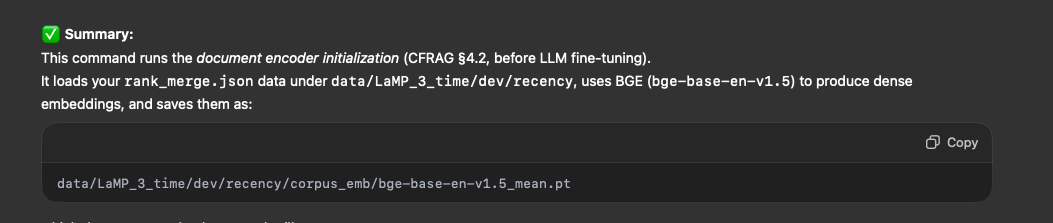


In [ ]:
!python /content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb/get_corpus_emb.py \
  --task LaMP_3_time --source recency --stage dev \
  --emb_model_path BAAI/bge-base-en-v1.5 \
  --emb_model_pooling cls \
  --emb_model_normalize 1 \
  --batch_size 128 --device cuda:0

CUDA_VISIBLE_DEVICES: 0,1
device: cuda:0
batch_size: 128
emb_model_path: BAAI/bge-base-en-v1.5
emb_model_pooling: cls
emb_type: mean
emb_model_normalize: 1
max_length: 512
task: LaMP_3_time
source: recency
stage: dev
input_path: data/LaMP_3_time/dev/recency
corpus_emb_path: data/LaMP_3_time/dev/recency/corpus_emb/bge-base-en-v1.5_mean.pt
2025-11-08 12:58:38.482894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762606718.502500   58732 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762606718.508398   58732 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762606718.522890   58732 computation_placer.cc:177] computation placer already regis

copying corpus embeddings to reuse


In [ ]:
# path to the file you just created
DEV_EMB="/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/corpus_emb/bge-base-en-v1.5_mean.pt"

# make sure the train corpus_emb dir exists
!mkdir -p /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/corpus_emb

# copy into the train slot (trainer will read from here)
!cp "$DEV_EMB" \
  /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/corpus_emb/bge-base-en-v1.5_mean.pt

  #-iname "*corpus*emb*"


train the user encoder (contrastive user retrieval – §4.1)

In [ ]:
%cd /content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb

/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb


Training UserEncoder using the precomputed corpus_emb

In [ ]:
%cd /content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb

# make sure the directory exists (optional)
!mkdir -p ./checkpoints

!python run.py \
  --task LaMP_3_time \
  --stage train \
  --source recency \
  --base_path /content/drive/MyDrive/bitirme_projesi/CFRAG_local \
  --model_name_or_path BAAI/bge-base-en-v1.5 \
  --corpus_emb_path /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/corpus_emb/bge-base-en-v1.5_mean.pt \
  --emb_pooling cls \
  --emb_normalize \
  --num_train_epochs 20 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --device cuda \
  --CUDA_VISIBLE_DEVICES 0 \
  --model_path /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints

/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb
tokenizer_config.json: 100% 366/366 [00:00<00:00, 2.90MB/s]
vocab.txt: 232kB [00:00, 23.6MB/s]
tokenizer.json: 711kB [00:00, 79.8MB/s]
special_tokens_map.json: 100% 125/125 [00:00<00:00, 1.33MB/s]

Epoch: 0
100% 3305/3305 [10:13<00:00,  5.39it/s]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(

Epoch: 1
100% 3305/3305 [10:12<00:00,  5.40it/s]

Epoch: 2
100% 3305/3305 [10:13<00:00,  5.39it/s]

Epoch: 3
100% 3305/3305 [10:12<00:00,  5.40it/s]

Epoch: 4
100% 3305/3305 [10:11<00:00,  5.40i

38 — Python glob helper (recursively find newest .pt)

What it does: finds all checkpoint files (including nested timestamp folders) and selects the newest for inference. This avoids hard-coding a path.
Keep? ✅ KEEP (nice utility for evaluation/inference notebooks).

In [ ]:
import os, glob

# parent checkpoint directory
base = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints"

# find all .pt files recursively (including inside subfolders)
candidates = sorted(glob.glob(os.path.join(base, "**", "*.pt"), recursive=True))
print("Found .pt files:")
for c in candidates:
    print(c)

# pick the newest one
CKPT = candidates[-1]
print("\nUsing checkpoint:", CKPT)

Found .pt files:
/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251108-175724.pt
/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt
/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155406.pt
/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155737.pt

Using checkpoint: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155737.pt


What it does:
	•	Reads the checkpoint to infer max_profile_len (from pos.pe.weight.shape[0]),
	•	Builds ModelArguments/DataArguments/TrainingArguments to match the checkpoint,
	•	Instantiates UserEncoder, loads state_dict, moves to device, and sets eval().
This is your inference setup for using the trained user encoder.
Keep? ✅ KEEP (this is the clean, reproducible load path).
-- ikinci kodda dinamik alıyor


In [ ]:
import torch
from arguments import DataArguments, ModelArguments, TrainingArguments
from modeling import UserEncoder

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
CORPUS_EMB = f"{BASE}/data/LaMP_3_time/train/recency/corpus_emb/bge-base-en-v1.5_mean.pt"
CKPT = f"{BASE}/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155737.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Inspect ckpt to get its max_profile_len
state = torch.load(CKPT, map_location="cpu")
L_ckpt = state["pos.pe.weight"].shape[0]
print("ckpt max_profile_len:", L_ckpt)

# 2) Build args using the SAME length
model_args = ModelArguments(
    model_name_or_path="BAAI/bge-base-en-v1.5",
    emb_pooling="cls", emb_normalize=1, emb_dim=768,
    num_layers=1, num_heads=1, dropout=0.1,
    sim_metric="cosine", sim_map=False, sim_activate=None,
    infoNCE_temp=0.05, infoNCE_temp_learn=False
)
data_args = DataArguments(
    task="LaMP_3_time", stage="dev", source="recency",
    base_path=BASE, corpus_emb_path=CORPUS_EMB,
    max_profile_len=L_ckpt,   # <- match checkpoint
    freeze_emb=True
)
train_args = TrainingArguments(
    device=str(device),
    per_device_train_batch_size=64, per_device_eval_batch_size=64,
    user_emb_path=f"{BASE}/data/LaMP_3_time/dev/recency/user_emb.pt"
)

# 3) Build model and load weights
model = UserEncoder(model_args=model_args, data_args=data_args, train_args=train_args)
model.load_state_dict(state, strict=True)
model.eval().to(device)
print("Loaded OK with max_profile_len:", data_args.max_profile_len)

ckpt max_profile_len: 100


KeyboardInterrupt: 

In [ ]:
%cd /content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb
import os, glob
import torch
from arguments import DataArguments, ModelArguments, TrainingArguments
from modeling import UserEncoder


BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
CORPUS_EMB = f"{BASE}/data/LaMP_3_time/train/recency/corpus_emb/bge-base-en-v1.5_mean.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- pick the latest checkpoint automatically ---
ckpt_root = f"{BASE}/data/LaMP_3_time/train/recency/user_emb/checkpoints"
all_ckpts = sorted(glob.glob(os.path.join(ckpt_root, "**", "*.pt"), recursive=True))

print("Found checkpoints:")
for c in all_ckpts:
    print("  ", c)

CKPT = all_ckpts[-1]   # newest one (20-epoch run from 20251123-132435.pt)
print("\nUsing checkpoint:", CKPT)

# 1) Inspect ckpt to get its max_profile_len
state = torch.load(CKPT, map_location="cpu")
L_ckpt = state["pos.pe.weight"].shape[0]
print("ckpt max_profile_len:", L_ckpt)

# 2) Build args using the SAME length
model_args = ModelArguments(
    model_name_or_path="BAAI/bge-base-en-v1.5",
    emb_pooling="cls", emb_normalize=1, emb_dim=768,
    num_layers=1, num_heads=1, dropout=0.1,
    sim_metric="cosine", sim_map=False, sim_activate=None,
    infoNCE_temp=0.05, infoNCE_temp_learn=False
)

data_args = DataArguments(
    task="LaMP_3_time",
    stage="dev",           # for probing, 'dev' is fine
    source="recency",
    base_path=BASE,
    corpus_emb_path=CORPUS_EMB,
    max_profile_len=L_ckpt,   # <- match checkpoint
    freeze_emb=True
)

train_args = TrainingArguments(
    device=str(device),
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    user_emb_path=f"{BASE}/data/LaMP_3_time/dev/recency/user_emb.pt"
)

# 3) Build model and load weights
model = UserEncoder(model_args=model_args, data_args=data_args, train_args=train_args)
model.load_state_dict(state, strict=True)
model.eval().to(device)
print("Loaded OK with max_profile_len:", data_args.max_profile_len)

/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb
Found checkpoints:
   /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251108-175724.pt
   /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt
   /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155406.pt
   /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155737.pt
   /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251123-130804.pt
   /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251123-130804.pt/20251123-131832.pt
   /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/check

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Loaded OK with max_profile_len: 100


This will overwrite the old dev/recency/user_emb.pt with embeddings from your 20-epoch model.

In [ ]:
# === Step 2: export dev user embeddings with the NEW checkpoint ===
import os
from trainer import Trainer  # already available in this folder

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
DEV_DIR = f"{BASE}/data/LaMP_3_time/dev/recency"

# where dev user embeddings will be saved
USER_EMB_OUT = f"{DEV_DIR}/user_emb.pt"

# dev vocab dir where user_vocab.pkl and corpus2id.pkl live
print("DEV_DIR       :", DEV_DIR)
print("USER_EMB_OUT  :", USER_EMB_OUT)

# --- build DataArguments for *dev* split ---
data_args_dev = DataArguments(
    task="LaMP_3_time",
    stage="dev",          # <<< IMPORTANT
    source="recency",
    base_path=BASE,
    vocab_path=DEV_DIR,
    corpus_vocab_path=DEV_DIR,
    corpus_emb_path=f"{DEV_DIR}/corpus_emb/bge-base-en-v1.5_mean.pt",
    max_profile_len=data_args.max_profile_len,  # reuse 100 from ckpt
    freeze_emb=True,
)

# give Trainer some dummy model_path so os.makedirs() doesn't choke
DEV_MODEL_DIR = f"{DEV_DIR}/dev_export_model"
os.makedirs(DEV_MODEL_DIR, exist_ok=True)

train_args_dev = TrainingArguments(
    device=str(device),
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    user_emb_path=USER_EMB_OUT,
    model_path=DEV_MODEL_DIR,
)

print("\n=== dev data_args check ===")
for k, v in vars(data_args_dev).items():
    if k in ["vocab_path", "corpus_vocab_path", "corpus_emb_path", "max_profile_len"]:
        print(k, "=", v)

# --- build Trainer with the *already loaded* state dict ---
trainer = Trainer(
    model_args=model_args,
    data_args=data_args_dev,
    train_args=train_args_dev,
)

trainer.model.load_state_dict(state, strict=True)
trainer.model.to(device).eval()

# compute and save dev user embeddings
with torch.no_grad():
    trainer.get_user_emb()

print("\n✅ Saved NEW dev user embeddings to:", USER_EMB_OUT)

DEV_DIR       : /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency
USER_EMB_OUT  : /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/user_emb.pt

=== dev data_args check ===
vocab_path = /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency
corpus_vocab_path = /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency
corpus_emb_path = /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/corpus_emb/bge-base-en-v1.5_mean.pt
max_profile_len = 100


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]


✅ Saved NEW dev user embeddings to: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/user_emb.pt


This is a sanity/spot-check of inference


In [ ]:
import torch, pickle
from modeling import UserEncoder
from arguments import DataArguments, ModelArguments, TrainingArguments
import torch.nn.functional as F

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
DEV_DIR = f"{BASE}/data/LaMP_3_time/dev/recency"
CORPUS_EMB = f"{BASE}/data/LaMP_3_time/train/recency/corpus_emb/bge-base-en-v1.5_mean.pt"  # trained on train split; ok for test here
CKPT = f"{BASE}/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155737.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load dev vocab
with open(f"{DEV_DIR}/user_vocab.pkl","rb") as f: user_vocab = pickle.load(f)

# build args consistent with ckpt (max_profile_len=100)
model_args = ModelArguments(model_name_or_path="BAAI/bge-base-en-v1.5",
                            emb_pooling="cls", emb_normalize=1, emb_dim=768,
                            num_layers=1, num_heads=1, dropout=0.1,
                            sim_metric="cosine", sim_map=False, sim_activate=None,
                            infoNCE_temp=0.05, infoNCE_temp_learn=False)
data_args  = DataArguments(task="LaMP_3_time", stage="dev", source="recency",
                           base_path=BASE, corpus_emb_path=CORPUS_EMB,
                           max_profile_len=100, freeze_emb=True)
train_args = TrainingArguments(device=str(device), user_emb_path=f"{DEV_DIR}/user_emb.pt",
                               per_device_train_batch_size=64, per_device_eval_batch_size=64)

model = UserEncoder(model_args, data_args, train_args).to(device)
state = torch.load(CKPT, map_location=device)
model.load_state_dict(state, strict=True)
model.eval()

def pack_user(idx, max_len=100, pad_id=0):
    ids = user_vocab[idx]["corpus_ids"][-max_len:]
    ids = [pad_id]*(max_len-len(ids)) + ids
    t = torch.tensor([ids], dtype=torch.long, device=device)
    mask = (t==pad_id)
    return t, mask

u = 0
t, m = pack_user(u, max_len=data_args.max_profile_len)
with torch.no_grad():
    emb = model.get_user_emb(t, m)            # [1,768]
    emb = F.normalize(emb, p=2, dim=-1)       # cosine space
print("user", u, "embedding shape:", tuple(emb.shape))
print("first 6 dims:", emb[0,:6].tolist())

user 0 embedding shape: (1, 768)
first 6 dims: [0.008623544126749039, -0.03254865109920502, -0.01373821310698986, -0.09430588781833649, -0.0880085676908493, -0.02185535617172718]


In [ ]:
import torch, pickle, os

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
DEV_DIR = f"{BASE}/data/LaMP_3_time/dev/recency"

USER_EMB_PATH   = f"{DEV_DIR}/user_emb.pt"
CORPUS_EMB_PATH = f"{DEV_DIR}/corpus_emb/bge-base-en-v1.5_mean.pt"

print("USER_EMB_PATH   :", USER_EMB_PATH)
print("CORPUS_EMB_PATH :", CORPUS_EMB_PATH)

# load tensors
user_emb   = torch.load(USER_EMB_PATH,   map_location="cpu")
corpus_emb = torch.load(CORPUS_EMB_PATH, map_location="cpu")

print("user_emb shape  :", user_emb.shape)
print("corpus_emb shape:", corpus_emb.shape)

with open(os.path.join(DEV_DIR, "user_vocab.pkl"), "rb") as f:
    user_vocab = pickle.load(f)

with open(os.path.join(DEV_DIR, "corpus_vocab.pkl"), "rb") as f:
    corpus_vocab = pickle.load(f)

print("users in dev vocab :", len(user_vocab))
print("docs in dev corpus:", len(corpus_vocab))

USER_EMB_PATH   : /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/user_emb.pt
CORPUS_EMB_PATH : /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/corpus_emb/bge-base-en-v1.5_mean.pt
user_emb shape  : torch.Size([105750, 768])
corpus_emb shape: torch.Size([340767, 768])
users in dev vocab : 105750
docs in dev corpus: 340767


embedding normalization

In [ ]:
import torch.nn.functional as F

# Normalize embeddings for cosine similarity
user_emb_norm   = F.normalize(user_emb,   p=2, dim=1)
corpus_emb_norm = F.normalize(corpus_emb, p=2, dim=1)

print("Normalized shapes:", user_emb_norm.shape, corpus_emb_norm.shape)

Normalized shapes: torch.Size([105750, 768]) torch.Size([340767, 768])


In [ ]:
def retrieve_docs_for_user(uid, top_k=5):
    u = user_emb_norm[uid]                 # [768]
    scores = corpus_emb_norm @ u           # dot → cosine
    top = torch.topk(scores, k=top_k)
    return top.indices.tolist(), top.values.tolist()

uid = 0  # or any user
doc_ids, scores = retrieve_docs_for_user(uid, top_k=5)

print("User:", user_vocab[uid]["user_id"])
for rank, (d, s) in enumerate(zip(doc_ids, scores), start=1):
    doc = corpus_vocab[d]
    print(f"\nRank {rank} | score={s:.4f}")
    print("doc_id:", doc["id"])
    print("corpus text:", doc["corpus"][:200], "...")

User: 1987461233

Rank 1 | score=0.3772
doc_id: 222839
corpus text: Bye puffy eyes I like the packaging because love a good pump. Compared to other eye serums I really enjoyed the texture and ease of this; the product isn’t watery which of a lot of the ones I’ve used  ...

Rank 2 | score=0.2777
doc_id: 233002
corpus text: Finding this product has been a game changer for helping the redness on my face. My skin became noticeably calmer and smooth after the first two week of use. Yes, it is pricey but know a little bit go ...

Rank 3 | score=0.2764
doc_id: 273247
corpus text: Perfect Love this! It’s an awesome lip balm and it doesn’t taste like sunblock like most ones with SPF do. Also a great price ...

Rank 4 | score=0.2667
doc_id: 190908
corpus text: Really Works! Wow! After a couple uses, my pores on my nose look a lot smaller! I did feel a little bit of a tingling sensation the first use, but nothing crazy. This is so easy to use and excited to  ...

Rank 5 | score=0.2666
doc_id: 116

This is a sanity/spot-check of inference -- bu önceye ait ve optional


In [ ]:
import torch, pickle
from modeling import UserEncoder
from arguments import DataArguments, ModelArguments, TrainingArguments
import torch.nn.functional as F

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
DEV_DIR = f"{BASE}/data/LaMP_3_time/dev/recency"
CORPUS_EMB = f"{BASE}/data/LaMP_3_time/train/recency/corpus_emb/bge-base-en-v1.5_mean.pt"  # trained on train split; ok for test here
CKPT = f"{BASE}/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155737.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load dev vocab
with open(f"{DEV_DIR}/user_vocab.pkl","rb") as f: user_vocab = pickle.load(f)

# build args consistent with ckpt (max_profile_len=100)
model_args = ModelArguments(model_name_or_path="BAAI/bge-base-en-v1.5",
                            emb_pooling="cls", emb_normalize=1, emb_dim=768,
                            num_layers=1, num_heads=1, dropout=0.1,
                            sim_metric="cosine", sim_map=False, sim_activate=None,
                            infoNCE_temp=0.05, infoNCE_temp_learn=False)
data_args  = DataArguments(task="LaMP_3_time", stage="dev", source="recency",
                           base_path=BASE, corpus_emb_path=CORPUS_EMB,
                           max_profile_len=100, freeze_emb=True)
train_args = TrainingArguments(device=str(device), user_emb_path=f"{DEV_DIR}/user_emb.pt",
                               per_device_train_batch_size=64, per_device_eval_batch_size=64)

model = UserEncoder(model_args, data_args, train_args).to(device)
state = torch.load(CKPT, map_location=device)
model.load_state_dict(state, strict=True)
model.eval()

def pack_user(idx, max_len=100, pad_id=0):
    ids = user_vocab[idx]["corpus_ids"][-max_len:]
    ids = [pad_id]*(max_len-len(ids)) + ids
    t = torch.tensor([ids], dtype=torch.long, device=device)
    mask = (t==pad_id)
    return t, mask

u = 0
t, m = pack_user(u, max_len=data_args.max_profile_len)
with torch.no_grad():
    emb = model.get_user_emb(t, m)            # [1,768]
    emb = F.normalize(emb, p=2, dim=-1)       # cosine space
print("user", u, "embedding shape:", tuple(emb.shape))
print("first 6 dims:", emb[0,:6].tolist())

user 0 embedding shape: (1, 768)
first 6 dims: [0.034360673278570175, -0.0842539593577385, 0.01969776675105095, -0.06565860658884048, -0.023317787796258926, -0.017061321064829826]


2- USER RETRİEVAL


In [ ]:
BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
!ls -lh "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb"

total 47K
-rw------- 1 root root 2.8K Nov  6 11:22 arguments.py
drwx------ 2 root root 4.0K Nov  8 17:54 checkpoints
-rw------- 1 root root 5.9K Nov  6 11:22 data.py
-rw------- 1 root root 3.4K Nov  6 11:21 get_corpus_emb.py
-rw------- 1 root root 6.2K Nov  8 11:36 get_user_set.py
-rw------- 1 root root 7.7K Nov  9 14:32 modeling.py
drwx------ 2 root root 4.0K Nov  8 10:04 __pycache__
-rw------- 1 root root 2.3K Nov  6 11:22 run.py
-rw------- 1 root root 7.4K Nov 23 11:27 trainer.py
-rw------- 1 root root 1.8K Nov  8 10:01 utils.py


In [ ]:
import torch
from arguments import DataArguments, ModelArguments, TrainingArguments
from modeling import UserEncoder

In [ ]:
# 1) Go to the user_emb training folder so local imports work
%cd "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb"

import os
import torch
from arguments import DataArguments, ModelArguments, TrainingArguments
from trainer import Trainer

# === Global base ===
BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
device = "cuda" if torch.cuda.is_available() else "cpu"

# === Paths ===
CKPT = f"{BASE}/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155737.pt"
CORPUS_EMB = f"{BASE}/data/LaMP_3_time/train/recency/corpus_emb/bge-base-en-v1.5_mean.pt"
DEV_DIR = f"{BASE}/data/LaMP_3_time/dev/recency"
USER_EMB_OUT = f"{DEV_DIR}/user_emb.pt"

print("Checkpoint:", CKPT)
print("Dev vocab dir:", DEV_DIR)
print("Will save dev user_emb to:", USER_EMB_OUT)

# 2) Inspect checkpoint → get max_profile_len
state = torch.load(CKPT, map_location="cpu")
L_ckpt = state["pos.pe.weight"].shape[0]
print("ckpt max_profile_len:", L_ckpt)

# 3) Build arguments
model_args = ModelArguments(
    model_name_or_path="BAAI/bge-base-en-v1.5",
    emb_pooling="cls",
    emb_normalize=1,
    emb_dim=768,
    num_layers=1,
    num_heads=1,
    dropout=0.1,
    sim_metric="cosine",
    sim_map=False,
    sim_activate=None,
    infoNCE_temp=0.05,
    infoNCE_temp_learn=False,
)

data_args = DataArguments(
    task="LaMP_3_time",
    stage="dev",
    source="recency",
    base_path=BASE,
    vocab_path=DEV_DIR,
    corpus_vocab_path=DEV_DIR,
    corpus_emb_path=CORPUS_EMB,
    max_profile_len=L_ckpt,
    freeze_emb=True,
)

# VALID model_path to avoid NoneType error
DEV_MODEL_DIR = f"{DEV_DIR}/dummy_model_dir"
os.makedirs(DEV_MODEL_DIR, exist_ok=True)

train_args = TrainingArguments(
    device=str(device),
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    user_emb_path=USER_EMB_OUT,
    model_path=DEV_MODEL_DIR,    # <-- MUST STAY
)

print("\n=== data_args DUMP ===")
for k, v in vars(data_args).items():
    if k in ["vocab_path", "corpus_vocab_path", "corpus_emb_path", "max_profile_len"]:
        print(k, "=", v)

# 4) Compute dev user embeddings
trainer = Trainer(model_args=model_args, data_args=data_args, train_args=train_args)
trainer.model.load_state_dict(state, strict=True)
trainer.model.to(device).eval()

with torch.no_grad():
    trainer.get_user_emb()

print("\n✅ Done. Saved dev user embeddings to:", USER_EMB_OUT)

/content/drive/MyDrive/bitirme_projesi/CFRAG_local/user_emb/train_user_emb
Checkpoint: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/user_emb/checkpoints/20251109-154346.pt/20251109-155737.pt
Dev vocab dir: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency
Will save dev user_emb to: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/user_emb.pt
ckpt max_profile_len: 100

=== data_args DUMP ===
vocab_path = /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency
corpus_vocab_path = /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency
corpus_emb_path = /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/corpus_emb/bge-base-en-v1.5_mean.pt
max_profile_len = 100


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



✅ Done. Saved dev user embeddings to: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/user_emb.pt


In [ ]:
import torch, pickle, os

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"

# --- paths for the *dev / recency* split ---
DEV_DIR = f"{BASE}/data/LaMP_3_time/dev/recency"
USER_EMB_PATH   = f"{DEV_DIR}/user_emb.pt"
CORPUS_EMB_PATH = f"{DEV_DIR}/corpus_emb/bge-base-en-v1.5_mean.pt"

print("USER_EMB_PATH   :", USER_EMB_PATH)
print("CORPUS_EMB_PATH :", CORPUS_EMB_PATH)

# load tensors
user_emb   = torch.load(USER_EMB_PATH,   map_location="cpu")   # [num_users, d]
corpus_emb = torch.load(CORPUS_EMB_PATH, map_location="cpu")   # [num_docs, d]

print("user_emb shape  :", user_emb.shape)
print("corpus_emb shape:", corpus_emb.shape)

# optional: load vocab / metadata
with open(os.path.join(DEV_DIR, "user_vocab.pkl"), "rb") as f:
    user_vocab = pickle.load(f)

with open(os.path.join(DEV_DIR, "corpus_vocab.pkl"), "rb") as f:
    corpus_vocab = pickle.load(f)

print("users in dev vocab :", len(user_vocab))
print("docs in dev corpus:", len(corpus_vocab))
print("sample user keys   :", list(user_vocab[0].keys()))
print("sample corpus keys :", list(corpus_vocab[0].keys()))

USER_EMB_PATH   : /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/user_emb.pt
CORPUS_EMB_PATH : /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/dev/recency/corpus_emb/bge-base-en-v1.5_mean.pt
user_emb shape  : torch.Size([105750, 768])
corpus_emb shape: torch.Size([340767, 768])
users in dev vocab : 105750
docs in dev corpus: 340767
sample user keys   : ['user_id', 'id', 'profile', 'corpus_ids']
sample corpus keys : ['corpus', 'id']


-4.2.1 DOCUMENT RETRİEVAL


In [ ]:
# NORMALİZE EMBEDDİNGS
import torch
import torch.nn.functional as F

# (already loaded earlier)
# user_emb, corpus_emb

user_emb_norm   = F.normalize(user_emb, p=2, dim=1)
corpus_emb_norm = F.normalize(corpus_emb, p=2, dim=1)

In [ ]:
#Choose a user and compute top-K documents
user_idx = 0
u = user_emb_norm[user_idx]             # (768,)

scores = (corpus_emb_norm @ u)          # (340767,)
topk = torch.topk(scores, k=20)

top_scores = topk.values
top_doc_indices = topk.indices.tolist()

In [ ]:
#Inspect retrieved documents
for rank, doc_id in enumerate(top_doc_indices, start=1):
    doc = corpus_vocab[doc_id]
    print(f"Rank {rank} — score {float(top_scores[rank-1]):.4f}")
    print("Document ID:", doc['id'])
    print("Corpus text:", doc['corpus'])
    print("----")

Rank 1 — score 0.6723
Document ID: 222839
Corpus text: Bye puffy eyes I like the packaging because love a good pump. Compared to other eye serums I really enjoyed the texture and ease of this; the product isn’t watery which of a lot of the ones I’ve used are but instead it’s more like a lightweight mousse texture. I used it twice a day morning/evening for 8 weeks it did help with my puffy eyes when I didn’t get enough sleep and left it hydrated the next day. The color of the product is a light orange due to the vitamin c, it doesn’t have any strong scent, and it didn’t irritate my skin; I would buy this again. I would also gift & recommend it to friends & family.
----
Rank 2 — score 0.5327
Document ID: 300254
Corpus text: Necessary I use this almost daily, for a super low-maintenance look.I use expensive skincare products at night and I change my sheets and pillowcases super frequently, so washing my face every morning seems like overkill (I’m 31 now, if I were younger and still acne-p

producing a dictionary of retrieved documents for all users - run later

In [ ]:
#producing a dictionary of retrieved documents for all users
TOP_K = 50
all_user_docs = {}

for uid in range(len(user_emb_norm)):
    u = user_emb_norm[uid]
    scores = corpus_emb_norm @ u
    top = torch.topk(scores, k=TOP_K).indices.tolist()
    all_user_docs[uid] = top


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F
import pickle, os

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
DEV_DIR = f"{BASE}/data/LaMP_3_time/dev/recency"

USER_EMB_PATH   = f"{DEV_DIR}/user_emb.pt"
CORPUS_EMB_PATH = f"{DEV_DIR}/corpus_emb/bge-base-en-v1.5_mean.pt"

print("Loading embeddings...")
user_emb   = torch.load(USER_EMB_PATH,   map_location="cpu")   # [num_users, d]
corpus_emb = torch.load(CORPUS_EMB_PATH, map_location="cpu")   # [num_docs, d]

print("user_emb:",   user_emb.shape)
print("corpus_emb:", corpus_emb.shape)

# normalize for cosine similarity
user_emb_norm   = F.normalize(user_emb,   p=2, dim=1)
corpus_emb_norm = F.normalize(corpus_emb, p=2, dim=1)

# load vocab for inspection
with open(os.path.join(DEV_DIR, "user_vocab.pkl"), "rb") as f:
    user_vocab = pickle.load(f)

with open(os.path.join(DEV_DIR, "corpus_vocab.pkl"), "rb") as f:
    corpus_vocab = pickle.load(f)

print("users in dev:", len(user_vocab))
print("docs in dev :", len(corpus_vocab))

def retrieve_docs_for_user(user_id: int, top_k: int = 20):
    """
    Return top_k document indices and scores for a given user_id (dev split).
    """
    u = user_emb_norm[user_id:user_id+1]            # [1, d]
    scores = torch.matmul(corpus_emb_norm, u.T).squeeze(1)  # [num_docs]
    top_scores, top_idx = torch.topk(scores, k=top_k)
    return top_idx.tolist(), top_scores.tolist()

Loading embeddings...
user_emb: torch.Size([105750, 768])
corpus_emb: torch.Size([340767, 768])
users in dev: 105750
docs in dev : 340767


In [ ]:
uid = 0  # or any index < len(user_vocab)
top_idx, top_scores = retrieve_docs_for_user(uid, top_k=5)

print("User:", user_vocab[uid]["user_id"])
for rank, (doc_i, s) in enumerate(zip(top_idx, top_scores), start=1):
    print(f"\nRank {rank} | score={float(s):.4f}")
    print("doc_id:", corpus_vocab[doc_i]["id"])
    print("corpus text:", corpus_vocab[doc_i]["corpus"][:200], "...")

User: 1987461233

Rank 1 | score=0.6723
doc_id: 222839
corpus text: Bye puffy eyes I like the packaging because love a good pump. Compared to other eye serums I really enjoyed the texture and ease of this; the product isn’t watery which of a lot of the ones I’ve used  ...

Rank 2 | score=0.5327
doc_id: 300254
corpus text: Necessary I use this almost daily, for a super low-maintenance look.I use expensive skincare products at night and I change my sheets and pillowcases super frequently, so washing my face every morning ...

Rank 3 | score=0.5311
doc_id: 262155
corpus text: I have been on a major kick with resurfacing & evening out my skin complexion and texture and this serum hits both of those on the head. I love the formulation, it soaks into my skin nicely and fits g ...

Rank 4 | score=0.5269
doc_id: 127569
corpus text: This oil is soooo good! A little goes a long way and it wakes up my dull and aging skin and makes it look and feel plump and smooth and soft and glowing. It’s not g

In [ ]:
import torch
import torch.nn.functional as F
import pickle, os

BASE    = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
DEV_DIR = f"{BASE}/data/LaMP_3_time/dev/recency"

# 1) Load dev user & corpus embeddings (you already did this, keep if it’s above)
USER_EMB_PATH   = f"{DEV_DIR}/user_emb.pt"
CORPUS_EMB_PATH = f"{DEV_DIR}/corpus_emb/bge-base-en-v1.5_mean.pt"

user_emb   = torch.load(USER_EMB_PATH,   map_location="cpu")   # [U, d]
corpus_emb = torch.load(CORPUS_EMB_PATH, map_location="cpu")   # [D, d]

# 2) Normalize for cosine similarity
user_emb_norm   = F.normalize(user_emb,   dim=1)
corpus_emb_norm = F.normalize(corpus_emb, dim=1)  # may be useful later, but not needed for pure CF

# 3) Load vocab files (you already have this above – keep one copy only)
with open(os.path.join(DEV_DIR, "user_vocab.pkl"), "rb") as f:
    user_vocab = pickle.load(f)

with open(os.path.join(DEV_DIR, "corpus_vocab.pkl"), "rb") as f:
    corpus_vocab = pickle.load(f)

print("num users:", len(user_vocab))
print("num docs :", len(corpus_vocab))

num users: 105750
num docs : 340767


In [ ]:
def retrieve_docs_cf_for_user(
    uid: int,
    top_user_k: int = 50,
    top_doc_k: int = 50,
):
    """
    CFRAG-style collaborative retrieval:
    1) find top_user_k users closest to uid in user_emb space
    2) collect their interacted corpus_ids
    3) rank docs by weighted neighbor similarity
    """
    U = user_emb_norm.shape[0]
    assert 0 <= uid < U

    # (1) similarities to all other users
    u = user_emb_norm[uid:uid+1]             # [1, d]
    sims = (user_emb_norm @ u.T).squeeze(1)  # [U]
    sims[uid] = -1e9                         # exclude self

    # top similar users
    top_k = min(top_user_k, U-1)
    top_user_scores, top_user_idx = torch.topk(sims, k=top_k)
    top_user_idx   = top_user_idx.tolist()
    top_user_scores = top_user_scores.tolist()

    # (2) collect docs with neighbor-weighted scores
    doc_scores = {}  # doc_id -> score
    for rank, (nbr_id, nbr_sim) in enumerate(zip(top_user_idx, top_user_scores)):
        # optional rank-based weight (closer neighbors contribute more)
        # you can tweak this; simple choice:
        weight = float(top_k - rank) / top_k  # in (0,1]
        nbr_docs = user_vocab[nbr_id]["corpus_ids"]
        for d_id in nbr_docs:
            doc_scores[d_id] = doc_scores.get(d_id, 0.0) + weight

    if not doc_scores:
        return [], []

    # (3) sort docs by score and keep top_doc_k
    sorted_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
    top_docs = sorted_docs[:top_doc_k]
    doc_ids  = [d for d, s in top_docs]
    scores   = [s for d, s in top_docs]
    return doc_ids, scores

In [ ]:
uid = 0  # or any id < len(user_vocab)
doc_ids, scores = retrieve_docs_cf_for_user(uid, top_user_k=50, top_doc_k=5)

print("User:", user_vocab[uid]["user_id"])
for rank, (d_id, s) in enumerate(zip(doc_ids, scores), start=1):
    doc = corpus_vocab[d_id]
    print(f"\nRank {rank} | score={s:.4f}")
    print("doc_id:", doc["id"])
    print("corpus text:", doc["corpus"][:200], "...")

User: 1987461233

Rank 1 | score=1.0000
doc_id: 158415
corpus text: I bought this in hoping I could find an alternative to the Drunk Elephant Sukari Babyfacial. I liked the Moonfruit mask a lot, and the Lapis oil, so I thought I would try this.Ultimately, though, it’s ...

Rank 2 | score=1.0000
doc_id: 225310
corpus text: Throwing it in the trash I don’t know what’s up with this moisturizer. The consistency is horrible, and it just sat on top of my face and didn’t absorb. My face is an oily mess today. I used my reward ...

Rank 3 | score=0.9800
doc_id: 65847
corpus text: love it PEACE OUT WRINKLES is a great product, easy to apply and leaves skin feeling smooth and soft ...

Rank 4 | score=0.9600
doc_id: 54413
corpus text: Sort of does what it’s supposed to... helped fade some spots but also gave me little breakouts, even though I only used 1-2 times a week. I do have sensitive skin so I started slow. I’ll look for anot ...

Rank 5 | score=0.9400
doc_id: 332637
corpus text: turned my 

DOCUMENT CANDIDATE GENERATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/bitirme_projesi/CFRAG_local
!ls
import sys
sys.path.append('.')   # so 'data', 'prompts', etc. are importable


/content/drive/MyDrive/bitirme_projesi/CFRAG_local
CFRAG.ipynb  data  generation  LLMs  models  prompts  sephora_data  user_emb


Candidate generation

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/bitirme_projesi/CFRAG_local")

In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/bitirme_projesi/CFRAG_local"))

['data', 'user_emb', 'sephora_data', 'prompts', 'models', 'generation', 'LLMs', 'CFRAG.ipynb', 'metrics']


In [ ]:
!pip install -q "transformers>=4.41.0"

real candidate generation


In [ ]:
import os
import json

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"

# 1) Original LaMP-3-time questions
Q_PATH = f"{BASE}/data/LaMP_3_time/train/train_questions.json"

# 2) Where CFRAG expects the retrieval file
RETR_DIR = f"{BASE}/data/LaMP_3_time/train/recency/retrieval"
os.makedirs(RETR_DIR, exist_ok=True)

OUT_PATH = f"{RETR_DIR}/debug_retrieval.json"

print("Reading questions from:", Q_PATH)
with open(Q_PATH, "r") as f:
    questions = json.load(f)

grouped = []
K = 1   # number of reviews per question you want to use as docs

for q in questions:
    user_id = q["user_id"]
    query   = q["input"]        # product metadata text
    profile = q["profile"]

    if not profile:
        continue

    docs = []
    for idx, p in enumerate(profile[:K]):
        doc_text = p["text"]
        label    = int(p["label"])

        prompt = (
            "You are helping to match products to a user based on their reviews.\n\n"
            f"User ID: {user_id}\n\n"
            "User review:\n"
            f"{doc_text}\n\n"
            "Product description:\n"
            f"{query}\n\n"
            "Question: How satisfied would this user be with this product? "
            "Answer with a rating from 1 to 5."
        )

        docs.append({
            "id": f"{q['id']}::{idx}",
            "user_id": user_id,
            "user_sim": 1.0,
            "doc": doc_text,
            "input": prompt,
            "output": label,
        })

    grouped.append({
        "id": q["id"],
        "user_id": user_id,
        "query": query,      # ← top-level query
        "retrieval": docs,   # ← list of docs for this query
    })

print("Number of questions:", len(grouped))
print("First question object:\n", json.dumps(grouped[0], indent=2))

with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(grouped, f, indent=2, ensure_ascii=False)

print("\nSaved retrieval file to:", OUT_PATH)

Reading questions from: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/train_questions.json
Number of questions: 331801
First question object:
 {
  "id": "10000117144::P427415::0",
  "user_id": "10000117144",
  "query": "100% Organic Cold-Pressed Rose Hip Seed Oil | Skincare | Moisturizers | Face Oils | ingredients=['Rosa Canina Seed Oil.'] | highlights=['Vegan', 'Without Silicones', 'Alcohol Free', 'Gluten Free']",
  "retrieval": [
    {
      "id": "10000117144::P427415::0::0",
      "user_id": "10000117144",
      "user_sim": 1.0,
      "doc": "Literally a breath of fresh air I have acne prone skin and am reactive to most products. I recently switched to a new foundation that left my skin appearing dry and rough. I remembered I had received this as a sample sometime back and gave it a shot - it was literally like my skin could breathe - It seriously feels so good. Great texture, smells great, absorbs quickly without a greasy residue, and works well with my

In [ ]:
%cd "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
import sys
sys.path.append('.')

!python generation/generate_point.py \
  --task LaMP_3_time \
  --input_path recency \
  --source retrieval/ \
  --file_name debug_retrieval \
  --base_addr "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency" \
  --model_name Qwen2-1.5B-Instruct \
  --begin_idx 0 \
  --end_idx 5000 \
  --batch_size 4 \
  --max_new_tokens 64

/content/drive/MyDrive/bitirme_projesi/CFRAG_local
CUDA_VISIBLE_DEVICES: 0,1
random_seed: 2024
base_addr: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency
task: LaMP_3_time
input_path: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/debug_retrieval.json
source: retrieval/
file_name: debug_retrieval
model_name: Qwen2-1.5B-Instruct
begin_idx: 0
end_idx: 5000
max_new_tokens: 64
cutoff_len: 3000
batch_size: 4
output_dir: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/point_debug_retrieval_hf-64
model_path: Qwen/Qwen2-1.5B-Instruct
datasize: 5000
Traceback (most recent call last):
  File "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/generation/generate_point.py", line 139, in <module>
    get_text_template(tokenizer, ex["input"])
                                 ~~^^^^^^^^^
KeyError: 'input'


In [ ]:
import json

path = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/debug_retrieval.json"
with open(path, "r") as f:
    data = json.load(f)

print(len(data))
print(data[0].keys())

331801
dict_keys(['id', 'user_id', 'query', 'retrieval'])


mergeing data


In [ ]:
import os
import json

def join_retriever_and_llm(
    base_dir,
    rank_path="rank_merge.json",
    pred_dir="retrieval/point_debug_retrieval_hf-64",
    pred_files=None,
    out_name="joined_debug_qwen.json",
):
    """
    Join recency-based retriever signals from rank_merge.json
    with LLM point predictions from predictions_*.json.

    We assume:
      - rank_merge.json: one entry per (user, query),
        with `profile` = list of reviews sorted by recency.
      - predictions_*.json: grouped by user_id; for each user,
        `data` = list of predictions in the SAME order
        as the reviews we prompted to the LLM.

    Output: flat list of dicts:
      {
        "user_id": ...,
        "query": ...,
        "llm_pred": float,
        "retr_score": float   # 1 / (rank+1)
      }
    """

    # ---------- 1) Load retriever data ----------
    rank_file = os.path.join(base_dir, rank_path)
    print("Loading retriever file from:", rank_file)

    with open(rank_file, "r", encoding="utf-8") as f:
        retr_data = json.load(f)

    # Build user_id -> list of recency scores (in profile order)
    retr_scores_by_user = {}

    for ex in retr_data:
        uid = ex["user_id"]
        profile = ex.get("profile", [])
        # 1 / (rank+1) as recency score
        scores = [1.0 / (i + 1) for i in range(len(profile))]
        retr_scores_by_user[uid] = scores

    print("Built recency lists for", len(retr_scores_by_user), "users")

    # ---------- 2) Load predictions ----------
    pred_dir_full = os.path.join(base_dir, pred_dir)

    if pred_files is None:
        pred_files = sorted(
            fn for fn in os.listdir(pred_dir_full) if fn.endswith(".json")
        )

    pred_groups = []
    for fn in pred_files:
        path = os.path.join(pred_dir_full, fn)
        print("Loading predictions from:", path)
        with open(path, "r", encoding="utf-8") as f:
            groups = json.load(f)
        pred_groups.extend(groups)

    print("Total user groups in predictions:", len(pred_groups))

    # ---------- 3) Join by (user_id, index) ----------
    joined = []
    mismatched_lengths = 0

    for group in pred_groups:
        uid = group["user_id"]
        data_list = group["data"]

        retr_scores = retr_scores_by_user.get(uid)
        if retr_scores is None:
            # user not found in rank_merge
            mismatched_lengths += 1
            continue

        if len(retr_scores) != len(data_list):
            # some mismatch in numbers of docs vs predictions
            print(
                f"WARNING: user {uid} has "
                f"{len(retr_scores)} recency entries but "
                f"{len(data_list)} predictions"
            )
            mismatched_lengths += 1
            # align only on the minimum length
            n = min(len(retr_scores), len(data_list))
        else:
            n = len(data_list)

        for i in range(n):
            item = data_list[i]
            llm_pred = float(item["predict"])
            retr_score = retr_scores[i]

            joined.append(
                {
                    "user_id": uid,
                    "query": item.get("query"),
                    "llm_pred": llm_pred,
                    "retr_score": retr_score,
                }
            )

    print(
        f"Joined examples: {len(joined)} | users with length mismatch: {mismatched_lengths}"
    )

    # ---------- 4) Save ----------
    out_dir = os.path.join(base_dir, "retrieval")
    os.makedirs(out_dir, exist_ok=True)

    out_path = os.path.join(out_dir, out_name)
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(joined, f, indent=2, ensure_ascii=False)

    print("Saved joined file to:", out_path)
    return out_path

In [ ]:
BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency"

joined_path = join_retriever_and_llm(
    base_dir=BASE,
    rank_path="rank_merge.json",
    pred_dir="retrieval/point_debug_retrieval_hf-64",
    pred_files=["predictions_0-1561.json"],   # our debug prediction file
    out_name="joined_debug_qwen.json",
)

print("Joined file saved at:", joined_path)

Loading retriever file from: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/rank_merge.json
Built recency lists for 105750 users
Loading predictions from: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/point_debug_retrieval_hf-64/predictions_0-1561.json
Total user groups in predictions: 1561
Joined examples: 4210 | users with length mismatch: 67
Saved joined file to: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen.json
Joined file saved at: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen.json


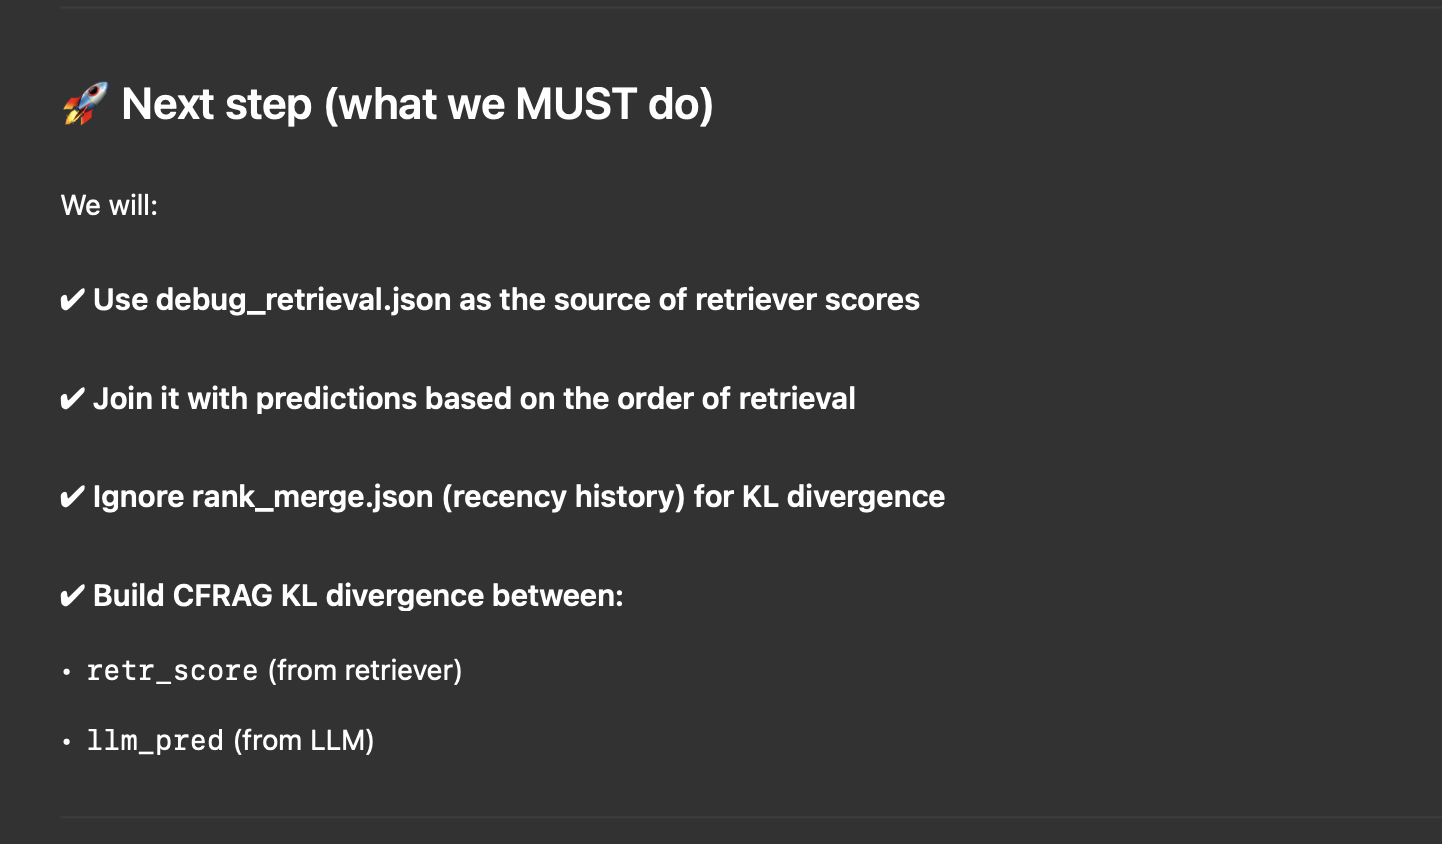

Flatten the candidate datset

In [ ]:
import os, json

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency"
in_path  = os.path.join(BASE, "retrieval", "debug_retrieval.json")
out_path = os.path.join(BASE, "retrieval", "debug_candidates.json")

with open(in_path, "r", encoding="utf-8") as f:
    groups = json.load(f)

flat = []
for g in groups:                 # one entry per (user, query)
    uid   = g["user_id"]
    query = g["query"]
    for cand in g["retrieval"]:  # loop over candidate docs
        flat.append({
            "id":       cand["id"],                  # candidate id
            "user_id":  uid,
            "user_sim": cand.get("user_sim", 1.0),
            "query":    query,
            "doc":      cand.get("doc") or cand.get("text", ""),
            "output":   cand.get("output"),          # gold rating for this doc
        })

print("num candidates:", len(flat))
print("example:", flat[0])

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(flat, f, indent=2, ensure_ascii=False)

print("Saved candidate file to:", out_path)

num candidates: 331801
example: {'id': '10000117144::P427415::0::0', 'user_id': '10000117144', 'user_sim': 1.0, 'query': "100% Organic Cold-Pressed Rose Hip Seed Oil | Skincare | Moisturizers | Face Oils | ingredients=['Rosa Canina Seed Oil.'] | highlights=['Vegan', 'Without Silicones', 'Alcohol Free', 'Gluten Free']", 'doc': 'Literally a breath of fresh air I have acne prone skin and am reactive to most products. I recently switched to a new foundation that left my skin appearing dry and rough. I remembered I had received this as a sample sometime back and gave it a shot - it was literally like my skin could breathe - It seriously feels so good. Great texture, smells great, absorbs quickly without a greasy residue, and works well with my acne reactive skin. Repurchase for sure.', 'output': 5}
Saved candidate file to: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/debug_candidates.json


In [ ]:


!python generate_point.py \
  --task LaMP_3_time \
  --base_addr "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval" \
  --input_path "" \
  --source "" \
  --file_name "debug_candidates" \
  --model_name Qwen2-1.5B-Instruct \
  --begin_idx 0 \
  --end_idx 5000 \
  --batch_size 4 \
  --max_new_tokens 64

CUDA_VISIBLE_DEVICES: 0,1
random_seed: 2024
base_addr: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval
task: LaMP_3_time
input_path: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/debug_candidates.json
source: 
file_name: debug_candidates
model_name: Qwen2-1.5B-Instruct
begin_idx: 0
end_idx: 5000
max_new_tokens: 64
cutoff_len: 3000
batch_size: 4
output_dir: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/point_debug_candidates_hf-64
model_path: Qwen/Qwen2-1.5B-Instruct
datasize: 5000
tokenizer_config.json: 1.29kB [00:00, 6.56MB/s]
vocab.json: 2.78MB [00:00, 98.9MB/s]
merges.txt: 1.67MB [00:00, 131MB/s]
tokenizer.json: 7.03MB [00:00, 184MB/s]
Loading HF model from: Qwen/Qwen2-1.5B-Instruct
config.json: 100% 660/660 [00:00<00:00, 5.30MB/s]
`torch_dtype` is deprecated! Use `dtype` instead!
2025-11-30 19:31:41.776862: E external/local_xla/xla/stream_executor/

In [ ]:
#buil join for prediction function


import json
import os

def parse_gold(item):
    """
    Try to recover a numeric gold label from the item.
    Prefer 'output' if numeric, otherwise fall back to 'label'.
    If neither is numeric, return None.
    """
    candidates = [item.get("output"), item.get("label")]

    for val in candidates:
        if val is None:
            continue
        # strip whitespace
        s = str(val).strip()
        if s == "":
            continue
        try:
            return float(s)
        except (ValueError, TypeError):
            continue
    return None


def build_join_from_predictions(pred_path, out_path):
    with open(pred_path, "r", encoding="utf-8") as f:
        groups = json.load(f)

    joined = []
    for g in groups:
        uid = g["user_id"]
        for item in g["data"]:
            joined.append({
                "user_id": uid,
                "query": item["query"],
                "doc": item["doc"],
                "retr_score": float(item.get("user_sim", 0.0)),      # retriever score
                "llm_pred": float(item["predict"]),                  # LLM rating (1–5)
                "gold": parse_gold(item),                            # may be None
                "id": item.get("id"),
            })

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(joined, f, indent=2, ensure_ascii=False)

    print(f"Saved joined training rows to: {out_path}")
    print("Num rows:", len(joined))

    #calling the function
pred_path = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/point_debug_candidates_hf-64/predictions_0-1561.json"
out_path  = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/joined/debug_joined_candidates.json"

build_join_from_predictions(pred_path, out_path)

Saved joined training rows to: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/joined/debug_joined_candidates.json
Num rows: 5000


KL-DIVERGENce

In [ ]:
import json, os
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
# 🔁 CHANGE THIS to your actual joined file path (the one you just printed “Rows: 5000” for)
JOINED_PATH = out_path  = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/joined/debug_joined_candidates.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
with open(JOINED_PATH, "r", encoding="utf-8") as f:
    joined = json.load(f)

print("Total rows:", len(joined))
print("Sample row keys:", joined[0].keys())
joined[0]

Total rows: 5000
Sample row keys: dict_keys(['user_id', 'query', 'doc', 'retr_score', 'llm_pred', 'gold', 'id'])


{'user_id': '10000117144',
 'query': "100% Organic Cold-Pressed Rose Hip Seed Oil | Skincare | Moisturizers | Face Oils | ingredients=['Rosa Canina Seed Oil.'] | highlights=['Vegan', 'Without Silicones', 'Alcohol Free', 'Gluten Free']",
 'doc': 'Literally a breath of fresh air I have acne prone skin and am reactive to most products. I recently switched to a new foundation that left my skin appearing dry and rough. I remembered I had received this as a sample sometime back and gave it a shot - it was literally like my skin could breathe - It seriously feels so good. Great texture, smells great, absorbs quickly without a greasy residue, and works well with my acne reactive skin. Repurchase for sure.',
 'retr_score': 1.0,
 'llm_pred': 5.0,
 'gold': 5.0,
 'id': '10000117144::P427415::0::0'}

In [ ]:
def make_query_id(row):
    """
    Make a stable query id from LaMP 'id' field.
    Example id: '10000117144::P427415::0::0'  ->  '10000117144::P427415'
    """
    rid = row.get("id")
    if rid is None:
        # fallback: user + query text
        return f"{row['user_id']}::{row['query']}"
    parts = str(rid).split("::")
    if len(parts) >= 2:
        return f"{parts[0]}::{parts[1]}"
    return str(rid)

In [ ]:
# @title
#Now convert to a list of tensors.
#We only keep groups with ≥2 docs (otherwise KL on a single item is meaningless).
import json
from collections import defaultdict

joined_train_path = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen.json"

with open(joined_train_path, "r", encoding="utf-8") as f:
    rows = json.load(f)          # this is your list of 5000 rows

print("Rows in joined file:", len(rows))

# group by (user_id, query)
groups = defaultdict(list)
for r in rows:
    qid = (r["user_id"], r["query"])
    groups[qid].append(r)

print("Num (user, query) groups:", len(groups))
# quick sanity check
first_key = next(iter(groups))
print("Example key:", first_key)
print("Group size:", len(groups[first_key]))
dataset = []

for qid, docs in groups.items():
    if len(docs) < 2:
        continue

    retr_scores = [float(d["retr_score"]) for d in docs]
    llm_scores  = [float(d["llm_pred"]) for d in docs]

    dataset.append({
        "qid": qid,
        "retr": torch.tensor(retr_scores, dtype=torch.float32, device=device),
        "teacher": torch.tensor(llm_scores, dtype=torch.float32, device=device),
    })

print("Num query groups used:", len(dataset))
print("Example group size:", dataset[0]["retr"].shape[0])

Rows in joined file: 4210
Num (user, query) groups: 4186
Example key: ('10000117144', "100% Organic Cold-Pressed Rose Hip Seed Oil | Skincare | Moisturizers | Face Oils | ingredients=['Rosa Canina Seed Oil.'] | highlights=['Vegan', 'Without Silicones', 'Alcohol Free', 'Gluten Free']")
Group size: 1
Num query groups used: 16
Example group size: 2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# simple score scaler: s' = a * s + b
class ScoreScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.bias  = nn.Parameter(torch.tensor(0.0))

    def forward(self, scores):
        # scores: (k,)
        return self.scale * scores + self.bias

#Kl training loop
# hyper-params
tau = 0.5              # temperature for softmax
num_epochs = 10        # you can increase later
lr = 1e-2

model = ScoreScaler().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.KLDivLoss(reduction="batchmean")

print("Num query groups used for KL:", len(dataset))

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in dataset:
        retr = batch["retr"]      # shape (k,)
        teacher = batch["teacher"]  # shape (k,)

        # forward
        student_logits = model(retr)

        # distributions over documents for this (user,query)
        student_log_probs = F.log_softmax(student_logits / tau, dim=0)
        teacher_probs     = F.softmax(teacher / tau, dim=0)

        loss = criterion(student_log_probs, teacher_probs)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - KL loss: {avg_loss:.4f}")

Num query groups used for KL: 16
Epoch 1/10 - KL loss: 0.0312
Epoch 2/10 - KL loss: 0.0240
Epoch 3/10 - KL loss: 0.0181
Epoch 4/10 - KL loss: 0.0133
Epoch 5/10 - KL loss: 0.0095
Epoch 6/10 - KL loss: 0.0067
Epoch 7/10 - KL loss: 0.0046
Epoch 8/10 - KL loss: 0.0030
Epoch 9/10 - KL loss: 0.0020
Epoch 10/10 - KL loss: 0.0012


In [ ]:
import torch
import torch.nn as nn

class KLHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)
kl_head = KLHead()
#freeze and save the kl head
import torch
import os

save_dir = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/models"
os.makedirs(save_dir, exist_ok=True)

kl_path = os.path.join(save_dir, "kl_head_debug.pt")
torch.save(kl_head.state_dict(), kl_path)

print("Saved KL head to:", kl_path)

Saved KL head to: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/models/kl_head_debug.pt


In [ ]:
#producing calibrated scores

import json
import torch

# paths
joined_path = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen.json"
out_path = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen_calibrated.json"
kl_path = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/models/kl_head_debug.pt"

# load data
with open(joined_path, "r") as f:
    data = json.load(f)

# load KL head
kl_head = KLHead()
kl_head.load_state_dict(torch.load(kl_path, map_location="cpu"))
kl_head.eval()
print("KL head loaded.")

# apply
for item in data:
    x = torch.tensor([[item["retr_score"]]], dtype=torch.float32)
    calibrated = kl_head(x).item()
    item["retr_score_calibrated"] = calibrated

# save
with open(out_path, "w") as f:
    json.dump(data, f, indent=2, ensure_ascii=False)

print("Wrote calibrated file to:", out_path)
print("Total rows:", len(data))

KL head loaded.
Wrote calibrated file to: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen_calibrated.json
Total rows: 4210


In [ ]:
#sanity check
import json
import numpy as np

path = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen_calibrated.json"
with open(path, "r") as f:
    data = json.load(f)

orig = np.array([d["retr_score"] for d in data])
cal  = np.array([d["retr_score_calibrated"] for d in data])
llm  = np.array([d["llm_pred"] for d in data])

print("orig mean/std:", orig.mean(), orig.std())
print("cal  mean/std:", cal.mean(),  cal.std())
print("llm  mean/std:", llm.mean(),  llm.std())

# correlations
print("corr(orig, llm):", np.corrcoef(orig, llm)[0,1])
print("corr(cal,  llm):", np.corrcoef(cal,  llm)[0,1])

orig mean/std: 0.5786380688459073 0.34272633225533766
cal  mean/std: 0.08922207522562167 0.030272746792735086
llm  mean/std: 4.141805225653207 0.7465426694518941
corr(orig, llm): -0.025273185498237215
corr(cal,  llm): -0.028612827233510805


In [ ]:
import json
from collections import Counter, defaultdict
import numpy as np

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
JOIN_PATH = f"{BASE}/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen_calibrated.json"

print("Loading:", JOIN_PATH)
with open(JOIN_PATH, "r", encoding="utf-8") as f:
    rows = json.load(f)

print("Total rows:", len(rows))

# Group by query (product)
groups = defaultdict(list)
for r in rows:
    q = r.get("query", "")
    if q is None:
        q = ""
    groups[q].append(r)

group_sizes = [len(v) for v in groups.values()]
num_groups = len(group_sizes)

print("\nNumber of distinct queries (groups):", num_groups)
print("Min group size:", min(group_sizes))
print("Max group size:", max(group_sizes))
print("Mean group size:", float(np.mean(group_sizes)))
print("Median group size:", float(np.median(group_sizes)))

# How many queries have at least k items?
for k in [1, 2, 3, 5, 10]:
    cnt = sum(1 for s in group_sizes if s >= k)
    print(f"Groups with ≥ {k} items: {cnt} ({cnt/num_groups:.2%})")

# Histogram of group sizes (truncated)
size_counts = Counter(group_sizes)
print("\nTop 15 group-size frequencies (size: count):")
for size, cnt in sorted(size_counts.items())[:15]:
    print(f"  {size}: {cnt}")

# Show a couple of example queries with multiple items
multi_examples = [q for q, v in groups.items() if len(v) >= 3][:3]
print("\nSample queries with ≥3 items:")
for q in multi_examples:
    print("-" * 80)
    print("Query:", q[:300], "..." if len(q) > 300 else "")
    print("Group size:", len(groups[q]))

Loading: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen_calibrated.json
Total rows: 4210

Number of distinct queries (groups): 1033
Min group size: 1
Max group size: 45
Mean group size: 4.0755082284607935
Median group size: 2.0
Groups with ≥ 1 items: 1033 (100.00%)
Groups with ≥ 2 items: 653 (63.21%)
Groups with ≥ 3 items: 456 (44.14%)
Groups with ≥ 5 items: 276 (26.72%)
Groups with ≥ 10 items: 110 (10.65%)

Top 15 group-size frequencies (size: count):
  1: 380
  2: 197
  3: 121
  4: 59
  5: 44
  6: 42
  7: 31
  8: 28
  9: 21
  10: 21
  11: 12
  12: 18
  13: 8
  14: 8
  15: 5

Sample queries with ≥3 items:
--------------------------------------------------------------------------------
Query: 100% Organic Cold-Pressed Rose Hip Seed Oil | Skincare | Moisturizers | Face Oils | ingredients=['Rosa Canina Seed Oil.'] | highlights=['Vegan', 'Without Silicones', 'Alcohol Free', 'Gluten Free'] 
Group size: 11
----------------------

In [ ]:
# ==== KL TRAINING: BGE-frozen retriever head over query groups ====

!pip install -q sentence-transformers

import json
import os
import random
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

BASE = "/content/drive/MyDrive/bitirme_projesi/CFRAG_local"
JOIN_PATH = f"{BASE}/data/LaMP_3_time/train/recency/retrieval/joined_debug_qwen.json"
HEAD_SAVE_PATH = f"{BASE}/data/LaMP_3_time/train/recency/retrieval/retriever_kl_head.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 1) Load joined & group by query ---------------------------------
with open(JOIN_PATH, "r", encoding="utf-8") as f:
    joined = json.load(f)

print("Total rows in joined:", len(joined))
print("Example keys:", joined[0].keys())

# group rows by product (query text)
groups = defaultdict(list)
for row in joined:
    q = row.get("query")
    d = row.get("doc")
    lp = row.get("llm_pred")
    if q is None or d is None:
        continue
    try:
        lp_float = float(lp)
    except (TypeError, ValueError):
        continue  # skip rows where llm_pred is not numeric

    groups[q].append({
        "doc": d,
        "llm_pred": lp_float,
        "retr_score": float(row.get("retr_score", 0.0)),
        "user_id": row.get("user_id"),
        "id": row.get("id")
    })

# keep only groups with at least 2 docs (KL needs contrast)
group_list = [ (q, items) for q, items in groups.items() if len(items) >= 2 ]
print(f"Usable groups (>=2 docs): {len(group_list)}")

print(f"Usable groups (>=2 docs): {len(group_list)}")

if not group_list:
    print("\nNo usable groups with ≥2 docs were found.")
    print("Possible reasons:")
    print(" - Many rows had doc=None or missing query")
    print(" - llm_pred could not be parsed as float")
    print(" - joined_debug_qwen_calibrated.json is empty / wrong file")
    # Stop training if nothing to learn from
else:
    print("\nSample group:")
    print("Query:", group_list[0][0][:200], "...")
    print("Group size:", len(group_list[0][1]))


# --- 2) Load frozen BGE encoder --------------------------------------
bge = SentenceTransformer("BAAI/bge-base-en-v1.5", device=device)
bge.eval()
for p in bge.parameters():
    p.requires_grad = False

emb_dim = bge.get_sentence_embedding_dimension()
print("BGE embedding dim:", emb_dim)

# --- 3) Trainable retriever head (on top of [q_emb, doc_emb]) --------
class RetrieverHead(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(emb_dim * 2, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, 1)
        )

    def forward(self, q_emb, d_emb):
        """
        q_emb: [n, d], d_emb: [n, d]
        return: [n] scores
        """
        x = torch.cat([q_emb, d_emb], dim=-1)
        scores = self.fc(x).squeeze(-1)
        return scores

head = RetrieverHead(emb_dim).to(device)

# --- 4) Training setup -----------------------------------------------
epochs = 3
tau_teacher = 0.7   # temperature for LLM distribution
tau_student = 0.7   # temperature for retriever scores
lr = 1e-3

optimizer = torch.optim.Adam(head.parameters(), lr=lr)

print("\n=== Start KL training over query groups ===")
print("\n=== Start KL training over query groups ===")
for epoch in range(1, epochs + 1):
    random.shuffle(group_list)
    total_loss = 0.0
    n_batches = 0

    for step, (q, items) in enumerate(group_list):
        docs = [it["doc"] for it in items]
        teacher_scores = torch.tensor([it["llm_pred"] for it in items],
                                      dtype=torch.float32,
                                      device=device)

        # Embed query once, docs as a batch
        with torch.no_grad():
            q_emb = bge.encode([q], convert_to_tensor=True)          # [1, d]
            d_emb = bge.encode(docs, convert_to_tensor=True)         # [n, d]

        # expand query embedding to match docs
        q_emb_expanded = q_emb.expand(d_emb.size(0), -1)             # [n, d]

        # student scores from head
        student_scores = head(q_emb_expanded, d_emb)                 # [n]

        # teacher distribution (LLM) and student distribution (retriever)
        teacher_prob = torch.softmax(teacher_scores / tau_teacher, dim=-1)
        student_log_prob = torch.log_softmax(student_scores / tau_student, dim=-1)

        # KL( teacher || student )
        loss = F.kl_div(student_log_prob, teacher_prob,
                        reduction="batchmean", log_target=False)

        # 🔍 DEBUG: inspect the very first batch of the first epoch
        if epoch == 1 and step == 0:
            print("\nDEBUG – first batch")
            print("  group size n:", teacher_scores.shape[0])
            print("  teacher_scores:", teacher_scores.detach().cpu().numpy())
            print("  student_scores:", student_scores.detach().cpu().numpy())
            print("  teacher_prob:", teacher_prob.detach().cpu().numpy())
            print("  student_log_prob:", student_log_prob.detach().cpu().numpy())
            print("  KL loss (this batch):", loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / max(n_batches, 1)
    print(f"Epoch {epoch}/{epochs} - avg KL loss: {avg_loss:.6f}")

# --- 5) Save the head -------------------------------------------------
os.makedirs(os.path.dirname(HEAD_SAVE_PATH), exist_ok=True)
torch.save(head.state_dict(), HEAD_SAVE_PATH)
print("KL-trained retriever head saved to:", HEAD_SAVE_PATH)

Device: cuda
Total rows in joined: 4210
Example keys: dict_keys(['user_id', 'query', 'llm_pred', 'retr_score'])
Usable groups (>=2 docs): 0
Usable groups (>=2 docs): 0

No usable groups with ≥2 docs were found.
Possible reasons:
 - Many rows had doc=None or missing query
 - llm_pred could not be parsed as float
 - joined_debug_qwen_calibrated.json is empty / wrong file
BGE embedding dim: 768

=== Start KL training over query groups ===

=== Start KL training over query groups ===
Epoch 1/3 - avg KL loss: 0.000000
Epoch 2/3 - avg KL loss: 0.000000
Epoch 3/3 - avg KL loss: 0.000000
KL-trained retriever head saved to: /content/drive/MyDrive/bitirme_projesi/CFRAG_local/data/LaMP_3_time/train/recency/retrieval/retriever_kl_head.pt
